# Model Selection Lab
---


## Preliminaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold, ShuffleSplit, LeaveOneOut
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin # need these when use Classes to create custom transformers
import matplotlib.pyplot as plt

# Even though we are not using seaborn we can style the plots with it
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 500)

# When printing arrays, set_printoptions controls the format
np.set_printoptions(precision=3)

# Create a scorer function for cross-validation
sc = make_scorer(mean_squared_error)

# pick a seed
seed=0


---
## 1. Load Dataset and Build Model

In [2]:
# Read in subset of footballer data (we want to predict "overall")
data = pd.read_csv('footballer_reduced.csv')
data.head()


,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,Medium,58
1,29,183,80,High,65
2,35,183,78,High,67
3,24,178,72,Medium,69
4,23,173,73,Medium,70


In [3]:
data.describe()


,age,height_cm,weight_kg,overall
count,360.000000,360.000000,360.000000,360.000000
mean,24.966667,180.758333,74.513889,65.841667
std,4.772717,6.706330,6.703828,7.161872
min,17.000000,164.000000,58.000000,47.000000
25%,21.000000,175.000000,70.000000,61.750000
50%,24.000000,181.000000,75.000000,66.000000
75%,29.000000,185.250000,79.000000,71.000000
max,37.000000,197.000000,93.000000,89.000000


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            360 non-null    int64 
 1   height_cm      360 non-null    int64 
 2   weight_kg      360 non-null    int64 
 3   work_rate_att  360 non-null    object
 4   overall        360 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.2+ KB


In [5]:
data.work_rate_att.value_counts()
# Normally, a label with number of instances greater than 5% of the the total entries is considered statistically significant.
# Otherwise, we should do regrouping and come up with new labels that are all statistically significant.


work_rate_att
Medium    266
High       71
Low        23
Name: count, dtype: int64

In [6]:
# Turn category into numeric variables
# Label Encoding with sklearn LabelEncoder()
dataLE = data.copy()
label_encoder = LabelEncoder()
dataLE['work_rate_att']= label_encoder.fit_transform(dataLE['work_rate_att'])

print(dataLE.loc[dataLE['work_rate_att'] == 0].work_rate_att.count())
print(dataLE.loc[dataLE['work_rate_att'] == 1].work_rate_att.count())
print(dataLE.loc[dataLE['work_rate_att'] == 2].work_rate_att.count())
dataLE.head()


71
23
266


,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,2,58
1,29,183,80,0,65
2,35,183,78,0,67
3,24,178,72,2,69
4,23,173,73,2,70


In [7]:
# Turn category into numeric variables
# One-Hot Encoding with sklearn OneHotEncoder()
dataOHE = data.copy()
ohe = OneHotEncoder()

#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object
X = ohe.fit_transform(dataOHE.work_rate_att.values.reshape(-1,1)).toarray()

#To add this back into the original dataframe
dfOneHot = pd.DataFrame(X, columns = ["work_rate_att_"+str(int(i)) for i in range(3)])
dataOHE = pd.concat([dataOHE, dfOneHot], axis=1)

#droping the cwork_rate_att column
dataOHE = dataOHE.drop(['work_rate_att'], axis=1)

print(dataOHE[(dataOHE['work_rate_att_0'] == 1.0)].work_rate_att_0.count())
print(dataOHE[(dataOHE['work_rate_att_1'] == 1.0)].work_rate_att_1.count())
print(dataOHE[(dataOHE['work_rate_att_2'] == 1.0)].work_rate_att_2.count())

dataOHE.head()


71
23
266


,age,height_cm,weight_kg,overall,work_rate_att_0,work_rate_att_1,work_rate_att_2
0,20,175,70,58,0.0,0.0,1.0
1,29,183,80,65,1.0,0.0,0.0
2,35,183,78,67,1.0,0.0,0.0
3,24,178,72,69,0.0,0.0,1.0
4,23,173,73,70,0.0,0.0,1.0


In [8]:
# Turn category into numeric variables
# One-Hot Encoding with Pandas get_dummies()
model_data = data.copy()
model_data = pd.get_dummies(model_data, drop_first=True) # the dropped one is collinear to the other two

print(model_data[(model_data['work_rate_att_Low'] == 1.0)].work_rate_att_Low.count())
print(model_data[(model_data['work_rate_att_Medium'] == 1.0)].work_rate_att_Medium.count())
model_data.head()


23
266


,age,height_cm,weight_kg,overall,work_rate_att_Low,work_rate_att_Medium
0,20,175,70,58,False,True
1,29,183,80,65,False,False
2,35,183,78,67,False,False
3,24,178,72,69,False,True
4,23,173,73,70,False,True


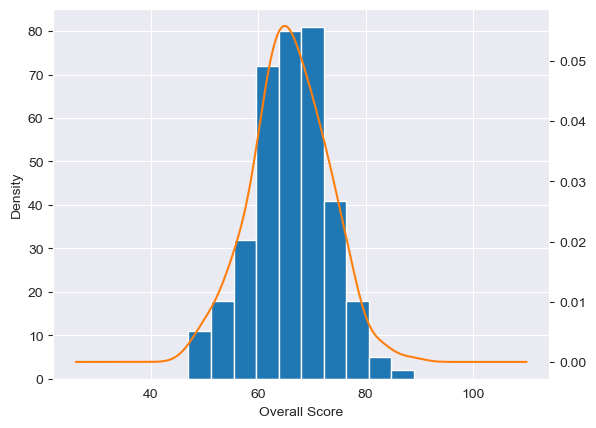

In [9]:
# Create histogram of target variable
ax = model_data.overall.plot(kind='hist')
model_data.overall.plot(kind='kde', ax=ax, secondary_y=True)
ax.set_xlabel("Overall Score")
plt.show()


In [10]:
# Define our X and y
X = model_data.drop('overall', axis = 'columns')
y = model_data.overall


In [11]:
# Split into train_&_validation and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state=seed)

print(Xtrain.shape, Xtest.shape)


(288, 5) (72, 5)


In [12]:
# Check training and test loss
linmodel = LinearRegression().fit(Xtrain, ytrain)

trainloss = mean_squared_error(ytrain, linmodel.predict(Xtrain))
print(f"Prediction Loss: %.3f" %  trainloss)

testloss = mean_squared_error(ytest, linmodel.predict(Xtest))
print(f"Generalization Loss: %.3f" % testloss)


Prediction Loss: 33.230
Generalization Loss: 40.952


## 2. Cross-validation: Define Partitions

Cross-validation gives an estimate of a model’s generalization performance.

For more details, see [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

For working with unbalanced classes, see [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

In [13]:
# Define Kfold cross-validation
x = np.arange(20)
print(x,'\n')
kf = KFold(n_splits=5, shuffle=False)
for train, test in kf.split(x):
    print("Train set: %s, Test set: %s" % (train, test))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 

Train set: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [0 1 2 3]
Train set: [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [4 5 6 7]
Train set: [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19], Test set: [ 8  9 10 11]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19], Test set: [12 13 14 15]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], Test set: [16 17 18 19]


In [14]:
# Define Kfold cross-validation with random shuffling
x=np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
for train,test in kf.split(x):
    print("Train set: %s, Test set: %s" % (train, test))


Train set: [ 0  2  3  4  5  7  9 10 11 12 13 15 16 17 18 19], Test set: [ 1  6  8 14]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 12 14 15 17 18], Test set: [11 13 16 19]
Train set: [ 0  1  3  4  6  7  8 10 11 12 13 14 15 16 18 19], Test set: [ 2  5  9 17]
Train set: [ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 18 19], Test set: [ 0  4 10 12]
Train set: [ 0  1  2  4  5  6  8  9 10 11 12 13 14 16 17 19], Test set: [ 3  7 15 18]


In [15]:
# Leave-one-out cross-validation.
# Useful for situations when dataset is too small and you cannot afford leaving out a test set, nor do a hold-out cross-validation.
# You will use the average of the parameters of the trained models (per fold) to get your final model.
# In other words, you are doing cross-validated test set evaluation.
x=np.arange(20)
loo = LeaveOneOut()

for train,test in loo.split(x):
    print("%s %s" % (train, test))


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [2]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [3]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [4]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [5]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19] [6]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19] [7]
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19] [8]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19] [9]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19] [10]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 1

## 3. Run Cross-validation

In [16]:
# KFold cross-validated loss without shuffling
kf = KFold(n_splits=5, shuffle=False, random_state=None)
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, scoring=sc, cv=kf)

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


List of CV loss: [30.107 39.038 33.24  33.382 37.925]
Average CV loss: 34.738 +/- 3.292


In [17]:
# Simpler way for doing KFold cross-validated loss without shuffling
nfolds=5
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, scoring=sc, cv=nfolds)

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


List of CV loss: [30.107 39.038 33.24  33.382 37.925]
Average CV loss: 34.738 +/- 3.292


In [18]:
# KFold cross-validated loss this time with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, cv=kf, scoring=sc)

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


List of CV loss: [32.168 32.547 27.698 49.119 31.711]
Average CV loss: 34.649 +/- 7.442


In [19]:
# Leave One Out cross-validated loss
# Use leave-one-out (LOO) when you have too little data.
# It is not a good choice for the "footballer" dataset and this cell is just for illustration.
kf = LeaveOneOut()
cv_scores = cross_val_score(LinearRegression(), X, y, cv=kf, scoring=sc)

# print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


Average CV loss: 35.832 +/- 50.553


## 4. Use Cross-validation to Find the Best Model

In [20]:
# first define a scorer and a cross_validation strategy
sc = make_scorer(mean_squared_error)

kf = KFold(n_splits=5, shuffle=False)
# kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=seed)


In [21]:
# Model 1
model1 = LinearRegression()
model1 = model1.fit(Xtrain, ytrain)

trainloss = mean_squared_error(ytrain, model1.predict(Xtrain))
print(f"Training loss: %.3f" % trainloss)

cv_scores = cross_val_score(model1, Xtrain, ytrain, cv=kf, scoring=sc)

print(f"CV loss:  %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


Training loss: 33.230
CV loss:  34.738 +/- 3.292


In [22]:
# Model 2: Squared trend for age
# Construct a new feature - age squared
Xtrain2 = Xtrain
Xtrain2 = Xtrain2.assign(age2 = Xtrain.age**2)

model2 = LinearRegression()
model2 = model2.fit(Xtrain2, ytrain)

trainloss = mean_squared_error(ytrain, model2.predict(Xtrain2))
print(f"Training loss: %.3f" % trainloss)

# Print CV scores and include standard deviation. Is it an unbiased estimate?
cv_scores = cross_val_score(model2, Xtrain2, ytrain, cv=kf, scoring=sc)

print(f"CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


Training loss: 30.500
CV loss: 32.066 +/- 1.157


In [23]:
# Model 3: All polynomial features
from regex import P


PT = PolynomialFeatures(degree=2)
Xtrain3 = PT.fit_transform(Xtrain)
print('Xtrain3 dimension is', Xtrain3.shape)

# Run the linear regression
model3 = LinearRegression().fit(Xtrain3,ytrain)

trainloss = mean_squared_error(ytrain,model3.predict(Xtrain3))
print(f"\nTraining loss: %.3f" % trainloss)

cv_scores = cross_val_score(model3, Xtrain3, ytrain, cv=kf, scoring=sc)

print(f"CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))


Xtrain3 dimension is (288, 21)

Training loss: 29.354
CV loss: 33.532 +/- 1.727


### Which model to choose?

Model 1.

Why?

Because we choose the simplest model that is within one standard deviation of the model which has the lowest cross-validation loss.

## 5. Pipelines

Pipelines allow us to "chain" different parts of a model building process. They are very useful to apply [transformations](https://scikit-learn.org/stable/data_transforms.html) to make sure that the transformations are being applied consistently in both training and production stages.

For illustration, we are going to use pipelines for creating quadratic and cubic features.

In [24]:
# Define the different pipelines
model1 = Pipeline([
    ('linear_regression', LinearRegression())
])

model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear_regression', LinearRegression())
])


### Pipelines accept any transformer that you can think of, even allowing the use of [classes](https://docs.python.org/3/tutorial/classes.html) to create a fully custom transformer. Below is an example.

In [25]:
# Model2 with custom transform
class Age2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.assign(age2 = X.age**2)
        return X

model2 = Pipeline([
    ('age2', Age2()),
    ('linear_regression', LinearRegression())
])


### You can also use [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).

In [26]:
# Check training loss
print(f"CV Loss (Model 1): %.3f +/- %.3f" %
      (cross_val_score(model1, Xtrain, ytrain, cv=kf, scoring=sc).mean(),
       cross_val_score(model1, Xtrain, ytrain, cv=kf, scoring=sc).std())
     )
print(f"CV Loss (Model 2): %.3f +/- %.3f" %
      (cross_val_score(model2, Xtrain, ytrain, cv=kf, scoring=sc).mean(),
       cross_val_score(model2, Xtrain, ytrain, cv=kf, scoring=sc).std())
     )
print(f"CV Loss (Model 3): %.3f +/- %.3f" %
      (cross_val_score(model3, Xtrain, ytrain, cv=kf, scoring=sc).mean(),
       cross_val_score(model3, Xtrain, ytrain, cv=kf, scoring=sc).std())
     )


CV Loss (Model 1): 34.738 +/- 3.292
CV Loss (Model 2): 32.066 +/- 1.157
CV Loss (Model 3): 33.532 +/- 1.727


In [27]:
# Now report generalization loss (test loss) on your final model.
# Always use an independent test set (hold-out test set) for this.
model1 = model1.fit(Xtrain,ytrain)
print(f"Test loss: %.3f" % mean_squared_error(ytest, model1.predict(Xtest)))


Test loss: 40.952


## 6. Learning Curves

If a model performs well on the training data but generalizes poorly according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex. A way to tell is to look at the learning curves: these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model.

In [28]:
def plot_learning_curves(model, X, y, rs):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Training Set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation Set")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Dataset Size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)


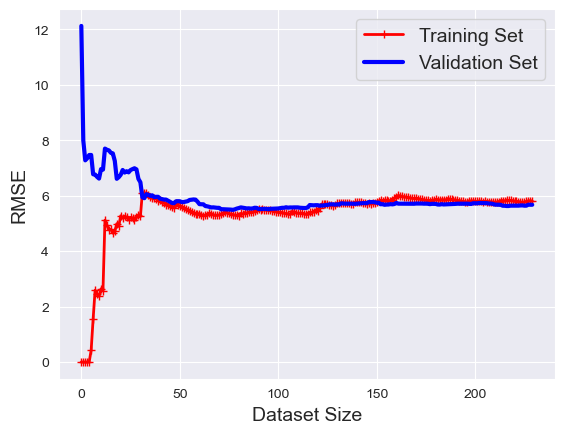

In [29]:
plot_learning_curves(LinearRegression(), Xtrain, ytrain, seed)

plt.show()


### Is your model underfitting or overfitting?

Underfitting.

First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, it could be because, for example, the data is noisy. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training data doesn’t make the average error much better or worse. Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve. These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and **fairly high**.

If your model is underfitting the training data, adding more training examples will not help. You need to use a more complex model or come up with a better set of features (*i.e.*, feature engineering).

In [30]:
otss = 70 # optimal training set size read from the learning curve

# (training Set Size)-(Validation Set Size) >= otss   i.e.,  (training Set Size)-((training Set Size)/N) >= otss
print(f'Lower bound on the number of folds (that is k in the k-fold)\
to be greater than {int(Xtrain.shape[0]/(Xtrain.shape[0]-otss))}.')


Lower bound on the number of folds (that is k in the k-fold)to be greater than 1.
